# Step 1: Import Packages & Spotify Authentication

In [1]:
import sys
import spotipy
import spotipy.util as util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

scope = 'user-library-read'
token = util.prompt_for_user_token("11100316938",scope,client_id='bddfdc9233b5493899809dcc42ca5cc3',client_secret='d97a1e581b5f4b4b9da348d6a0529e02',redirect_uri='http://localhost:5000/callback')
spotify = spotipy.Spotify(auth = token)

# Functions

## getPlaylistFeatures()
 returns an array with DataFrame of Tracks and Name of playlist in the following tuple
- (playlistDF, playlistName)

In [2]:
def getPlaylistFeatures(playlistURI, playlistNum):
    
    userPlaylistResponse = spotify.user_playlist("11100316938", playlistURI)
    playlistName = userPlaylistResponse["name"]
    
    #tracks are returned in this JSON response
    tracksResponse = spotify.user_playlist_tracks("11100316938", playlistURI)
    tracks = tracksResponse["items"]
    
    #instantiate an empty array and place the Tracks URI in this array
    tracksArray = [] 
    for track in tracks:
        URI = track["track"]["id"]
        tracksArray.append(URI)
    
    dfArray = [] #empty array the DataFrame will intake
    dfColumns = ["trackURI", "danceability", "energy", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "playlistNum"] #columns that make DataFrame
        
    #code to iterate through each track URI and get its respective features
    for trackURI in tracksArray:
        trackFeatures = spotify.audio_features(trackURI)
        
        danceability = trackFeatures[0]["danceability"]
        energy = trackFeatures[0]["energy"]
        speechiness = trackFeatures[0]["speechiness"]
        acousticness = trackFeatures[0]["acousticness"]
        instrumentalness = trackFeatures[0]["instrumentalness"]
        liveness = trackFeatures[0]["liveness"]
        valence = trackFeatures[0]["valence"]
        
        tempArray = [trackURI, danceability, energy, speechiness, acousticness, instrumentalness, liveness, valence, playlistNum]
        dfArray.append(tempArray)
        
    playlistDF = pd.DataFrame(dfArray, columns = dfColumns)
    return (playlistDF, playlistName)


# mostDissimilarFeatures(playlist1,playlist2)
- returns a dataframe with the most dissimilar features in descending order
- the dissimilarity is computed with Euclidean Distance between the means of each features respective to their playlist

In [3]:
def mostDissimilarFeatures(playlist1DF, playlist2DF):
#     playlist1 = getPlaylistFeatures(playlist1, 1)
#     playlist2 = getPlaylistFeatures(playlist2, 2)
    
    playlist1Mean = pd.DataFrame(playlist1DF[["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "liveness", "valence"]].mean(), columns = ["playlist1"])
    playlist2Mean = pd.DataFrame(playlist2DF[["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "liveness", "valence"]].mean(), columns = ["playlist2"])

    mergedMeans = playlist1Mean.join(playlist2Mean)
    
    differenced = mergedMeans.assign(absoluteDifference = lambda x: np.absolute(mergedMeans["playlist1"] - mergedMeans["playlist2"]))
    differenced = differenced.sort_values("absoluteDifference", ascending = False)

    display(differenced)
    playlist1Mean.plot(kind='bar')
    playlist2Mean.plot(kind='bar')

    topDissimilar = differenced.index
    
    return topDissimilar

# plotPlaylists(playlist1, playlist2)
- plots the top two dissimilar features amongsts the two playlist to help us visualize how different or similar they are

In [4]:
def plotPlaylists(playlist1, playlist2, feature1, feature2):
#     feature1 = "acousticness"
#     feature2 = "instrumentalness"

    playlist1DF = playlist1[0]
    playlist2DF = playlist2[0]
    
    playlist1Name = playlist1[1]
    playlist2Name = playlist2[1]

    plt.scatter(playlist1DF[feature1], playlist1DF[feature2], c = "r")
    plt.scatter(playlist2DF[feature1], playlist2DF[feature2], c = "g")
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend(labels = [playlist1Name, playlist2Name])
    plt.show

# KNNPredict(songURI, kNeighbors)
- this function will take a user input a song and tell you which playlist the song best belongs to using K-Nearest Neighbors Algorithm that is built into SciKit Learn
- Model is fitted from a dataFrame that contains the following:
    - Input: [feature1, feature2]
    - Output: Classification ... or which playlist those features belong to

In [5]:
def KNNPredict(kNeighbors, playlist1, playlist2, feature1, feature2, songFeatures):

    merge = [playlist1[0],playlist2[0]] 
    dfMerge = pd.concat(merge)

    features = dfMerge[[feature1,feature2]]
    classification = dfMerge['playlistNum']
    
    model = KNeighborsClassifier(n_neighbors=kNeighbors)
    model.fit(features, classification)
    
#     return(model)
    return(model.predict([songFeatures]))

# getSongFeatures(songURI)
- gets the features from the song to analyze and then eventually predict.
- returns a DataFrame of song features

In [6]:
def getSongFeature(songURI):
    features = spotify.audio_features(songURI)
    features = features[0]
    
    display(features)
    
    danceability = features["danceability"]
    energy = features["energy"]
    speechiness = features["speechiness"]
    acousticness = features["acousticness"]
    instrumentalness = features["instrumentalness"]
    liveness = features["liveness"]
    valence = features["valence"]
    
    dfArray = [danceability, energy, speechiness, acousticness, instrumentalness, liveness, valence] #empty array the DataFrame will intake
    dfColumns = ["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "liveness", "valence"] #columns that make DataFrame
    
    trackFeatures = pd.DataFrame(dfArray, index = dfColumns)
    trackFeatures = trackFeatures.transpose()
    return(trackFeatures)

# getSongName(songURI)

In [7]:
def getSongName(songURI):
    trackName = (spotify.track(songURI)["name"])
    return(trackName)

# Step 2: Input Playlist to Analyze
- Using two Spotify featured playlists' playlistID's

In [8]:
playlist1Input = '296W1tgCGPvAjyCSSdiUsG' #slow rock
playlist2Input = '37i9dQZF1DXcZDD7cfEKhW' #dance pop

# Step 3: Retrieve Playlists Information
- Call the function to retrieve the tracks from each playlists and their features
- We also get the playlist's name

In [9]:
playlist1 = getPlaylistFeatures(playlist1Input, 1)
playlist2 = getPlaylistFeatures(playlist2Input, 2)

#the variables above contain both a DataFrame and the name. We access them by parsing through the returned tuple
playlist1DF = playlist1[0]
playlist1Name = playlist1[1]

playlist2DF = playlist2[0]
playlist2Name = playlist2[1]

In [10]:
display(playlist1Name)
display(playlist1DF.head())

display(playlist2Name)
display(playlist2DF.head())

'Slow Rock (Greatest Hits)'

,trackURI,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,playlistNum
0,4YJ4n7DsZhR5hrnsMfn6zV,0.446,0.409,0.0368,0.2870,0.000000,0.0788,0.295,1
1,6Z435tBPT5JamUR9dN7y8y,0.486,0.487,0.0341,0.4450,0.000014,0.0648,0.373,1
2,2yX3h3NRoMWGfnXxZlF92X,0.334,0.188,0.0289,0.9320,0.000002,0.1220,0.223,1
3,5CQ30WqJwcep0pYcV4AMNc,0.338,0.340,0.0339,0.5800,0.003200,0.1160,0.197,1
4,4glXFaeaoBGLrh0lbe5Dgk,0.411,0.452,0.2220,0.0387,0.000003,0.0928,0.460,1


'Dance Pop'

,trackURI,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,playlistNum
0,6e0CvGZf7CouOpYF8toXHC,0.744,0.726,0.0463,0.0399,0.000000,0.3740,0.687,2
1,1hZ7LSB05aNMX2Nw73DFiR,0.968,0.677,0.2070,0.0306,0.000000,0.0852,0.767,2
2,3TjLsDgL0bTbSQIF6M5Ki8,0.678,0.747,0.1650,0.0395,0.000000,0.1740,0.516,2
3,3jwQwGVERUXo7eaAgL1xAo,0.493,0.773,0.1570,0.4290,0.000007,0.0807,0.301,2
4,7Feaw9WAEREY0DUOSXJLOM,0.726,0.722,0.0456,0.1730,0.000010,0.1410,0.345,2


# Step 3: Identify Most Dissimilar Features

,playlist1,playlist2,absoluteDifference
energy,0.519283,0.804549,0.285267
acousticness,0.258716,0.092297,0.166420
danceability,0.519228,0.661692,0.142464
valence,0.405374,0.454725,0.049351
liveness,0.150155,0.197941,0.047785
speechiness,0.050800,0.091090,0.040290
instrumentalness,0.023639,0.021233,0.002406


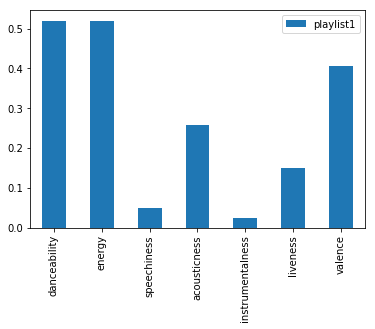

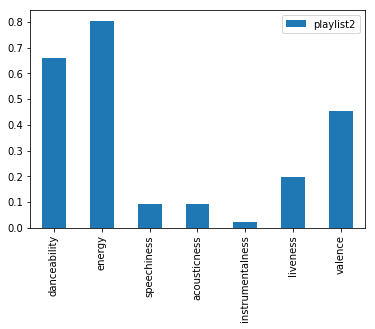

In [11]:
# we input the DataFrames for each playlist into the function
mostDissimilar = mostDissimilarFeatures(playlist1DF, playlist2DF)

# we only want the top 2 dissimilar features
top2Dissimilar = mostDissimilar.values.tolist() #conver to list to access
feature1 = top2Dissimilar[0]
feature2 = top2Dissimilar[1]

# Step 4: Plot Dissimilar Features

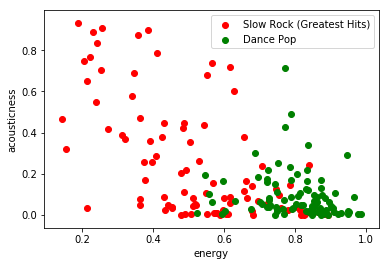

In [12]:
plotPlaylists(playlist1, playlist2, feature1, feature2)

# Step 5: Get Song Features
- get the features of the song that we want to see where it belongs

In [13]:
from sklearn.neighbors import KNeighborsClassifier
song = '46X0rddXGD4C5CJOBmHQqD' #Cem Karaca - Tamirci Ciragi

trackFeatures = getSongFeature(song)
trackName = getSongName(song)
trackFeature1 = trackFeatures.loc[0, feature1]
trackFeature2 = trackFeatures.loc[0, feature2]
#this array contains the values of our top two dissimilar features
trackFeatureValues = [trackFeature1, trackFeature2] 

{'danceability': 0.299,
 'energy': 0.526,
 'key': 8,
 'loudness': -12.091,
 'mode': 0,
 'speechiness': 0.323,
 'acousticness': 0.558,
 'instrumentalness': 5.57e-05,
 'liveness': 0.0801,
 'valence': 0.663,
 'tempo': 197.677,
 'type': 'audio_features',
 'id': '46X0rddXGD4C5CJOBmHQqD',
 'uri': 'spotify:track:46X0rddXGD4C5CJOBmHQqD',
 'track_href': 'https://api.spotify.com/v1/tracks/46X0rddXGD4C5CJOBmHQqD',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/46X0rddXGD4C5CJOBmHQqD',
 'duration_ms': 298253,
 'time_signature': 3}

# Step 6: Make the actual prediction using KNN
- make the prediction using K-Nearest Neighbors Algorithm and store that model into a variable *myModel*
- then proceed to output the prediciton

In [14]:
myModel = KNNPredict(25, playlist1, playlist2, feature1, feature2, trackFeatureValues)

In [15]:
if(myModel[0] == 1 ):
    print(trackName + "' best belongs in '" + playlist1Name + "' playlist")
else:
    print(trackName + "' best belongs in '" + playlist2Name + "' playlist")

Tamirci Çırağı' best belongs in 'Slow Rock (Greatest Hits)' playlist


## Plotting

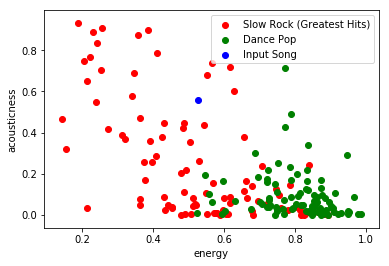

In [16]:
myPlot = plotPlaylists(playlist1, playlist2, feature1, feature2)
trackFeatureValues
plt.scatter(trackFeatureValues[0], trackFeatureValues[1], c = "b")
plt.legend([playlist1Name, playlist2Name,"Input Song"])

# Step 7: Homemade prediction
- Calculate the difference of 3 most dissimilar features of playlist1 and playlist2 with the input song's 3 most dissimilar features

In [17]:
differenceFromPlaylist1 = [0,0,0,0,0,0,0]
differenceSum = 0
for x in range(0, 7):
    differenceFromPlaylist1[x] = abs(playlist1DF.mean().values[x] - trackFeatures.mean().values[x])
    differenceSum += differenceFromPlaylist1[x]
print(differenceFromPlaylist1)
print(differenceSum)

[0.22022826086956532, 0.006717391304347897, 0.2722, 0.29928361956521754, 0.023583106739130423, 0.07005543478260867, 0.25762608695652156]
1.1496939002173914


In [18]:
differenceFromPlaylist2 = [0,0,0,0,0,0,0]
differenceSum2 = 0
for x in range(0, 7):
    differenceFromPlaylist2[x] = abs(playlist2DF.mean().values[x] - trackFeatures.mean().values[x])
    differenceSum2 += differenceFromPlaylist2[x]
print(differenceFromPlaylist2)
print(differenceSum2)

[0.3626923076923079, 0.27854945054945, 0.23190989010989013, 0.46570338461538463, 0.02117686703296703, 0.11784065934065932, 0.20827472527472535]
1.6861472846153847


In [25]:
SimilarityToPlaylist1 = ((7-differenceSum)*100)/7
print(trackName + ': Similarity to "' + playlist1Name + '" ' + str(SimilarityToPlaylist1) + '%')

Tamirci Çırağı: Similarity to "Slow Rock (Greatest Hits)" 83.57580142546583%


In [26]:
SimilarityToPlaylist2 = ((7-differenceSum2)*100)/7
print(trackName + ': Similarity to "' + playlist2Name + '" ' + str(SimilarityToPlaylist2) + '%')

Tamirci Çırağı: Similarity to "Dance Pop" 75.91218164835165%
